# EE 519 — Time-domain Analysis of speech (Notebook 0)
## Record and Explore Speech in the Time Domain

### What you’ll do
1. **Load a provided WAV** (baseline) and/or **record your own speech** (optional).
2. Record **vowels (voiced)**, **fricatives (unvoiced)**, and a **short sentence**, with **intentional silences**.
3. Record **soft / normal / loud** to see amplitude effects.
4. Visualize **nonstationarity** in the waveform and simple time-domain summaries.

> **Tip for a clean recording:** speak for ~4–6 seconds and include ~1 seconds of silence at the start and end.


---
## 0) Setup
We’ll use only core scientific Python libraries.

- If you can record from your laptop mic, we’ll try `sounddevice`.
- If recording doesn’t work on your machine, **upload a WAV file** and proceed.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

def to_mono(x):
    """Ensure mono float32 in [-1, 1]."""
    x = np.asarray(x)
    if x.ndim == 2:  # stereo -> mono
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def remove_dc(x):
    return x - np.mean(x)

def peak_normalize(x, target=0.95):
    peak = np.max(np.abs(x)) + 1e-12
    return np.clip(x * (target / peak), -1.0, 1.0)

def plot_waveform(x, fs, title="Waveform", tlim=None):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")    
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

def plot_zoom_grid(x, fs, regions, suptitle="Zoomed regions"):
    n = len(regions)
    plt.figure(figsize=(12, 2.5*n))
    for i, (label, t0, t1) in enumerate(regions, start=1):
        a = int(max(0, t0*fs))
        b = int(min(len(x), t1*fs))
        t = np.arange(a, b) / fs
        plt.subplot(n, 1, i)
        plt.plot(t, x[a:b], linewidth=0.9)
        plt.title(f"{label}: {t0:.3f}–{t1:.3f} s")
        plt.xlabel("Time (s)")
        plt.ylabel("Amp")
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle(suptitle, y=1.02, fontsize=14)
    plt.show()

def play_audio(x, fs):
    display(Audio(x, rate=fs))

---
## 1) Load a WAV/record

### Upload your own WAV
Upload a file in your Jupyter environment (e.g.,`speech.wav`) and, place it in the same folder as this notebook.


In [2]:
# ====== Choose your audio file here ======
wav_path = "speech.wav"  # <- change if needed

if not os.path.exists(wav_path):
    print(f"File not found: {wav_path}\nUpload a WAV and update wav_path.")
else:
    fs, x = wavfile.read(wav_path)
    x = to_mono(x)
    print("Loaded:", wav_path)
    print("Sampling rate (Hz):", fs)
    print("Duration (s):", len(x)/fs)

Loaded: speech.wav
Sampling rate (Hz): 16000
Duration (s): 4.0


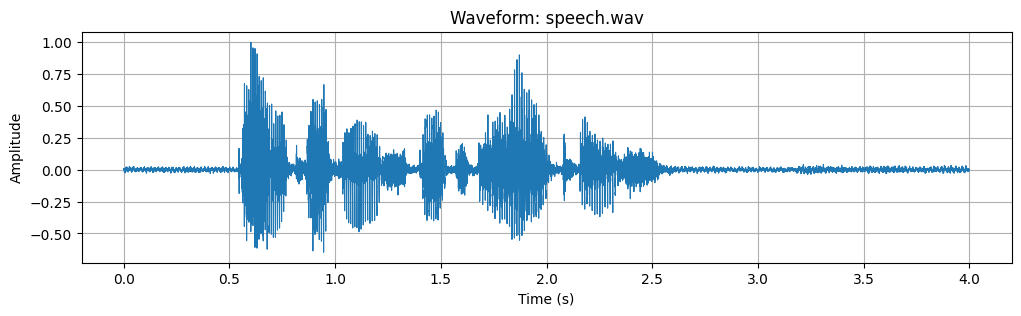

In [3]:
# Play and view the waveform (if loaded)
if "x" in globals():
    play_audio(x, fs)
    plot_waveform(x, fs, title=f"Waveform: {wav_path}")

---
## 2)Record your own speech 

Record something like:
- **Silence (1–2 s)**
- **Voiced vowels**: “aaaa”, “iiii”, “oooo”
- **Unvoiced fricatives**: “ssss”, “shhhh”
- **Short sentence**: “Today is a sunny day.”
- **Silence (1–2 s)**

Then repeat for **soft**, **normal**, and **loud** voice.

In [4]:
# Try to import sounddevice for microphone recording
try:
    import sounddevice as sd
    SOUNDDEVICE_OK = True
    print("sounddevice available ✅")    
except Exception as e:
    SOUNDDEVICE_OK = False
    print("sounddevice not available ❌") 
    print("If you can't record, just use a WAV file and continue.")

sounddevice available ✅


In [5]:
def record_audio(duration_s=8.0, fs=16000, channels=1):
    """Record audio from default microphone. Returns mono float32 signal."""
    if not SOUNDDEVICE_OK:
        raise RuntimeError("sounddevice is not available on this system.")
    print("Recording... speak now!")
    y = sd.rec(int(duration_s * fs), samplerate=fs, channels=channels, dtype="float32")
    sd.wait()
    y = y.squeeze()
    print("Done.")
    return y, fs

In [ ]:
#Record soft / normal / loud (optional)
#Uncomment and run if your mic works.

In [11]:
y_soft, fs_rec = record_audio(duration_s=12, fs=16000)

Recording... speak now!
Done.


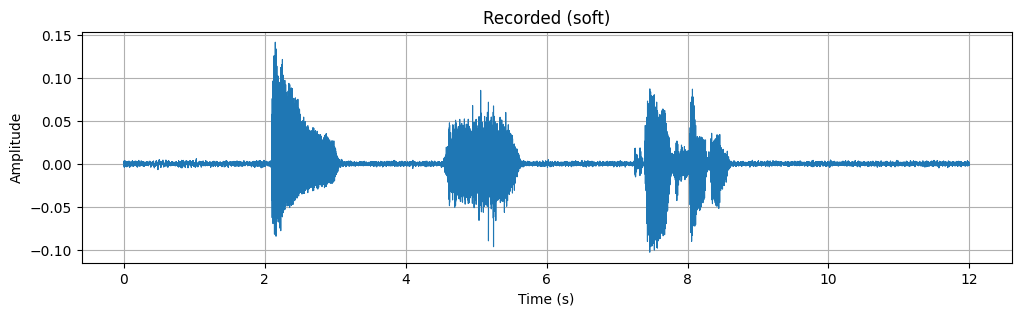

In [12]:
#After recording:
play_audio(y_soft, fs_rec)
plot_waveform(y_soft, fs_rec, title="Recorded (soft)")

In [13]:
y_norm, fs_rec = record_audio(duration_s=10, fs=16000)

Recording... speak now!
Done.


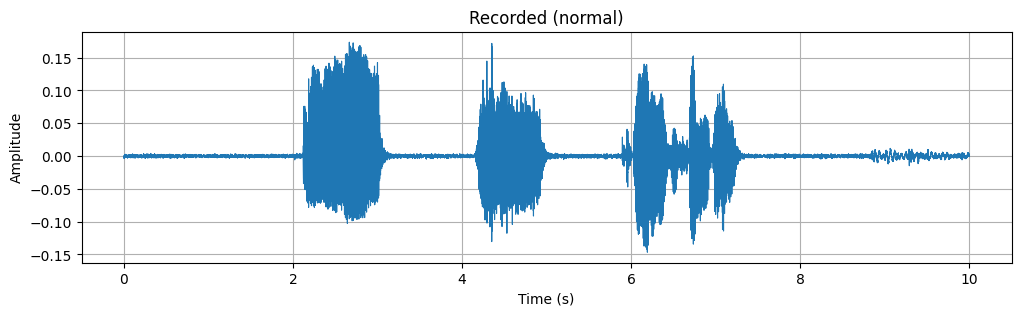

In [14]:
#After recording:
play_audio(y_norm, fs_rec)
plot_waveform(y_norm, fs_rec, title="Recorded (normal)")

In [15]:
y_loud, fs_rec = record_audio(duration_s=10, fs=16000)

Recording... speak now!
Done.


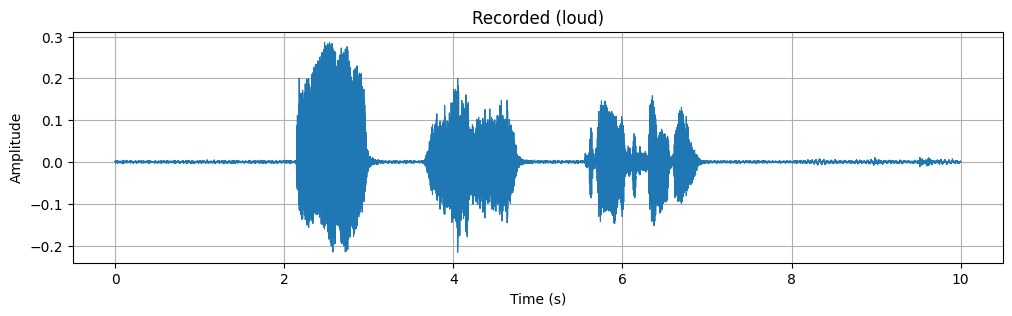

In [16]:
#After recording:
play_audio(y_loud, fs_rec)
plot_waveform(y_loud, fs_rec, title="Recorded (loud)")

---
## 3) Compare soft / normal / loud (amplitude effects)
If you recorded multiple takes, this section shows how amplitude changes.

If you only loaded one WAV, you can still run the analysis using that single file.


In [17]:
def summarize_signal(x, fs, name="signal"):
    x_dc = remove_dc(x)
    rms = np.sqrt(np.mean(x_dc**2))
    peak = np.max(np.abs(x_dc))
    print(f"{name}: duration={len(x)/fs:.2f}s | RMS={rms:.4f} | peak={peak:.4f}")

signals = []
if "x" in globals():
    signals.append(("loaded", x, fs))

for var, label in [("y_soft","soft"),("y_norm","normal"),("y_loud","loud")]:
    if var in globals():
        signals.append((label, globals()[var], fs_rec))

for name, sig, sfs in signals:
    summarize_signal(sig, sfs, name=name)

loaded: duration=4.00s | RMS=0.0930 | peak=1.0001
soft: duration=12.00s | RMS=0.0096 | peak=0.1411
normal: duration=10.00s | RMS=0.0187 | peak=0.1735
loud: duration=10.00s | RMS=0.0261 | peak=0.2865


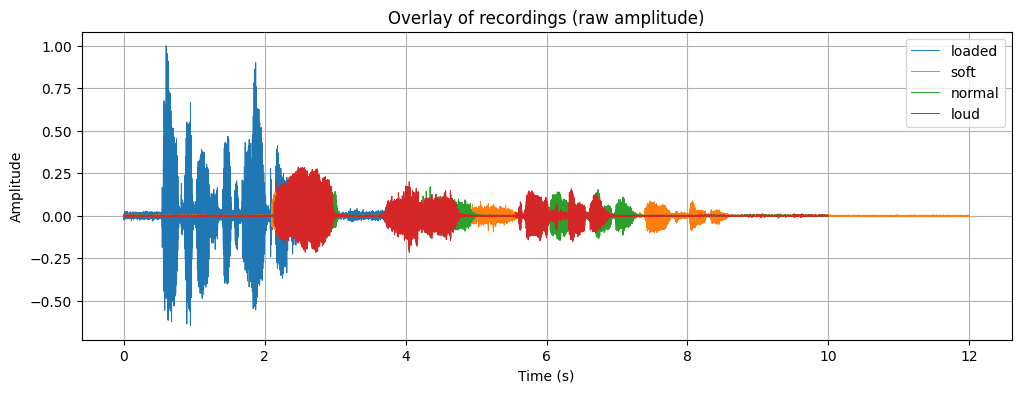

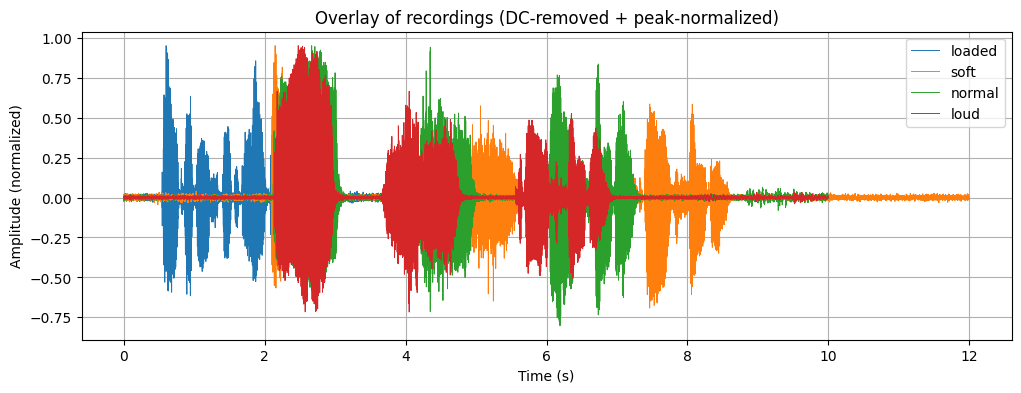

In [18]:
# Overlay waveforms for comparison (raw + peak-normalized)
if len(signals) >= 2:
    plt.figure(figsize=(12, 4))
    for name, sig, sfs in signals:
        t = np.arange(len(sig)) / sfs
        plt.plot(t, sig, linewidth=0.7, label=name)
    plt.title("Overlay of recordings (raw amplitude)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 4))
    for name, sig, sfs in signals:
        sig_n = peak_normalize(remove_dc(sig))
        t = np.arange(len(sig_n)) / sfs
        plt.plot(t, sig_n, linewidth=0.7, label=name)
    plt.title("Overlay of recordings (DC-removed + peak-normalized)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend()
    plt.show()
else:
    print("(Skip) Need at least 2 signals (e.g., soft/normal/loud) to compare overlays.")

---
## 4) Nonstationarity: see how speech changes over time
Speech is **nonstationary**: its properties change from silence → voiced → unvoiced → transitions.

Below, we’ll:
1. Plot the full waveform
2. Zoom into a few regions (you choose time ranges)

**Goal:** visually compare:
- **silence** (low amplitude)
- **voiced vowel** (quasi-periodic)
- **unvoiced fricative** (noise-like)


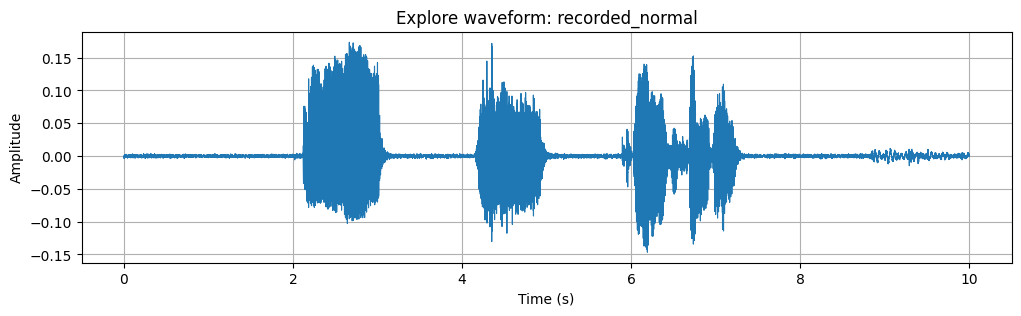

In [19]:
# Select which signal to explore
if "y_norm" in globals():
    sig_name, sig, fs_use = "recorded_normal", y_norm, fs_rec
elif "x" in globals():
    sig_name, sig, fs_use = "loaded", x, fs
else:
    raise RuntimeError("No audio available. Load a WAV or record audio.")

sig = to_mono(sig)
sig = np.clip(sig, -1.0, 1.0)

play_audio(sig, fs_use)
plot_waveform(sig, fs_use, title=f"Explore waveform: {sig_name}")

### Choose 3 regions to zoom
Set three time intervals (in seconds):
- **Silence** region
- **Voiced vowel** region
- **Unvoiced fricative** region

> Tip: Use the full waveform plot above to estimate where these regions are.


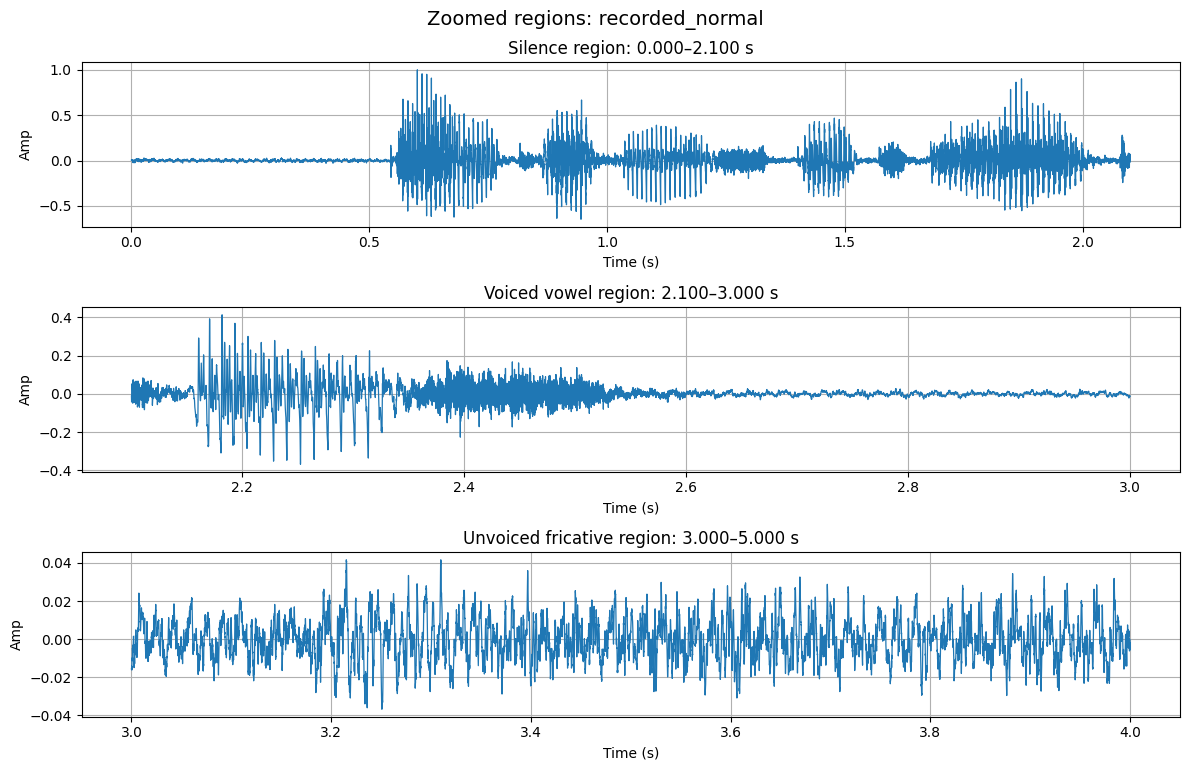

In [26]:
# Edit these after looking at the waveform plot
# regions = [
#     ("Silence region", 0.5, 1.5),
#     ("Voiced vowel region", 2.0, 2.2),
#     ("Unvoiced fricative region", 3.0, 3.2),
# ]

regions = [
    ("Silence region", 0, 2.1),
    ("Voiced vowel region", 2.1, 3.0),
    ("Unvoiced fricative region", 3.0, 5.0),
]

plot_zoom_grid(x, fs_use, regions, suptitle=f"Zoomed regions: {sig_name}")
#plot_zoom_grid(x/max(abs(x)), fs_use, regions, suptitle=f"Zoomed regions: {sig_name}")

In [22]:
from IPython.display import Audio
Audio(sig[int(0.5*fs_use):int(1.5*fs_use)], rate=fs_use)

---
## 5) Reflection questions (write your answers in a markdown cell)
1. In your **voiced vowel region**, what visual evidence suggests quasi-periodicity?
2. In your **unvoiced fricative region**, what visual evidence suggests noise-like behavior?
3. Compare **soft vs loud** recordings: what changes? what stays similar?

✅ When you’re done, move to **Notebook 1: Framing & Windowing**.


## Answers

1. We can see a regularly repeating pattern in the waveform. This is quasi-periodicity because the amplitude is similar but not exactly the same.
2. In this region the on the waveform we don't see a pattern that resembles periodicity which means its noise-like behavior.
3. The overlay on the graph shows that the louder recordings have higher amplitude. The duration of the sounds and timing was relatively similar.